<a href="https://colab.research.google.com/github/ZachFunk/3D-GAP-Masters-Thesis/blob/main/Final_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIP



In [1]:
! nvidia-smi
!pip install pytorch-lightning
!pip install tifffile
!pip install imagecodecs
!pip install wandb
from google.colab import drive
drive.mount('/content/drive')

Mon Sep  2 08:10:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Installation

In [6]:
# %load_ext autoreload
# %autoreload 2
import random
import sys
import gc
import os
import time
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from tifffile import imread, imsave, imwrite
from pathlib import Path
# import dataloader
import warnings
warnings.filterwarnings('ignore')

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, DeviceStatsMonitor
from pytorch_lightning.loggers import WandbLogger
import torch.optim as optim
import torch.utils.data as dt
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchmetrics

#from ProcessData import add_poisson_noise, split_data, calculate_snr, find_file, process_data
# import wandb
import wandb

################################################################################


if not torch.cuda.is_available():
    device = 'cpu'
else:
    device = torch.device("cuda:0")

print(f'Device: {device}')

from skimage.metrics import structural_similarity as ssim

# Set Python random seed
random.seed(42)

# Set NumPy seed
np.random.seed(42)

# Set PyTorch seed
torch.manual_seed(42)


data = tiff.imread('/content/drive/MyDrive/MastersThesis/data/Copy of clean_30Hz_256x256x(0-1000).tif')
data = torch.from_numpy(data)

maxepochs = 20
channels = 1


Device: cuda:0


# Functions

In [7]:
def add_poisson_noise(data, noise_scale):
    #normalize between 0, 255
    data = (data - data.min()) / (data.max() - data.min()) * 255
    noisy_data = torch.poisson(data * noise_scale) / noise_scale
    return data, noisy_data


def process_data(data, noise_scale, device='cpu', test=True):
    # Move data to the specified device
    data = data.to(device)

    gt_data, noisy_data = add_poisson_noise(data, noise_scale)
    gt_data, noisy_data = gt_data.to(device), noisy_data.to(device)

    snr = calculate_snr(gt_data, noisy_data)
    rounded_snr = round(snr)

    _, _, gt_test, noisy_train, noisy_val, noisy_test = split_data(gt_data, noisy_data)

    # Move results back to CPU before returning
    gt_test = gt_test.to('cpu')
    noisy_test = noisy_test.to('cpu')
    noisy_train = noisy_train.to('cpu')
    noisy_val = noisy_val.to('cpu')

    temp_dict = {}
    if test:
        temp_dict[rounded_snr] = {
            'noisy_test': noisy_test,
            'gt_test': gt_test
        }
    else:
        temp_dict[rounded_snr] = {
            'noisy_train': noisy_train,
            'noisy_val': noisy_val
        }

    return temp_dict


def calculate_snr(gt_data, noisy_data):
    """
    Calculate the overall SNR for a dataset of images with channel dimension.

    Parameters:
    - gt_data (torch.Tensor): The ground truth image tensor. Should be of shape (N, H, W).
    - noisy_data (torch.Tensor): The noisy image tensor. Should be of shape (N, H, W).

    Returns:
    - overall_snr_db (float): The overall SNR for the dataset in dB.
    """

    # Calculate signal power for all images at once
    signal_power = torch.mean(gt_data ** 2, dim=(-1, -2,-3))

    # Calculate noise for all images at once
    noise = noisy_data - gt_data

    # Calculate noise power for all images at once
    noise_power = torch.mean(noise ** 2, dim=(-1, -2,-3))

    # Calculate overall SNR for all images
    overall_snr = torch.mean(signal_power / noise_power)

    # Convert to dB
    overall_snr_db = 10 * torch.log10(overall_snr)

    return overall_snr_db.item()



def split_data(ground_truth, noisy_data, train_ratio=0.7, val_ratio=0.15):
    """
    Splits ground truth and noisy data into train, validation, and test sets.

    Parameters:
    - ground_truth: PyTorch tensor of ground truth data
    - noisy_data: PyTorch tensor of noisy data
    - train_ratio: proportion of data to be used for training
    - val_ratio: proportion of data to be used for validation

    Returns:
    - gt_train, gt_val, gt_test: ground truth data splits as PyTorch tensors
    - noisy_train, noisy_val, noisy_test: noisy data splits as PyTorch tensors
    """

    # Check if data tensors are of the same length
    if ground_truth.size(0) != noisy_data.size(0):
        raise ValueError("Ground truth and noisy data must have the same length.")

    # Compute split indices
    total_sequences = ground_truth.size(0)
    train_end = int(total_sequences * train_ratio)
    val_end = int(total_sequences * (train_ratio + val_ratio))

    # Split the data
    gt_train = ground_truth[:train_end]
    gt_val = ground_truth[train_end:val_end]
    gt_test = ground_truth[val_end:]

    noisy_train = noisy_data[:train_end]
    noisy_val = noisy_data[train_end:val_end]
    noisy_test = noisy_data[val_end:]

    return gt_train, gt_val, gt_test, noisy_train, noisy_val, noisy_test


# Create Data

In [8]:
# Define noise levels
test_noise_values = [0.0000094, 0.0000298, 0.000100, 0.0003, 0.00095, 0.003, 0.0095, 0.030,
                     0.094,
                     0.30,0.95,2.99]

train_noise_values = [3.0]

# Initialize dictionaries
test_dict = {}
train_dict = {}

# Process test data
for noise in test_noise_values:
    results = process_data(data, noise_scale=noise, test=True, device=device)
    test_dict.update(results)

# Process training data
for noise in train_noise_values:
    results = process_data(data, noise_scale=noise, test=False, device=device)
    train_dict.update(results)

# Get the SNR keys of the dictionaries
snr_keys_train = list(train_dict.keys())
snr_keys_test = list(test_dict.keys())

# Access inner keys using the SNR key
inner_keys_train = train_dict[snr_keys_train[0]].keys() if snr_keys_train else []
inner_keys_test = test_dict[snr_keys_test[0]].keys() if snr_keys_test else []

print(f'Train PSNR: {snr_keys_train}')
print(f'  Datasets: {list(inner_keys_train)}\n')

print(f'Test PSNR: {snr_keys_test}')
print(f' Datasets: {list(inner_keys_test)}')

print()

Train PSNR: [15]
  Datasets: ['noisy_train', 'noisy_val']

Test PSNR: [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15]
 Datasets: ['noisy_test', 'gt_test']



Noisy train shape:       torch.Size([700, 256, 256])
Noisy Val Shape:         torch.Size([150, 256, 256])


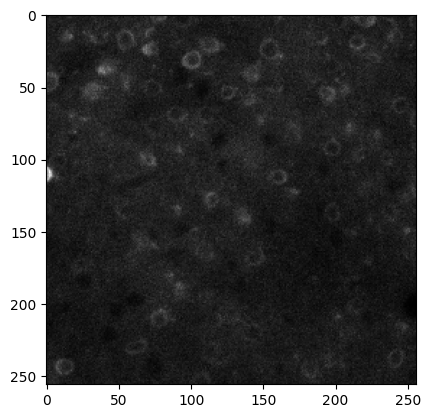

In [9]:
noisy_train = train_dict[15].get('noisy_train')
print(f'Noisy train shape:       {noisy_train.shape}')

noisy_val = train_dict[15].get('noisy_val')
print(f'Noisy Val Shape:         {noisy_val.shape}')
plt.imshow(noisy_train[0], cmap = 'gray')
plt.show()

# BinomDataset3D Uniform


In [10]:
import torch
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as tf
from numpy.random import randint

class BinomDataset3D_Uniform(torch.utils.data.Dataset):
    '''
    Returns a BinomDataset that will randomly split an image into input and target using a binomial distribution for each voxel.

            Parameters:
                    data (numpy array): a 3D numpy array (channels,depth, height, width) with integer photon counts.
                    windowSize (tuple): size of window to be used in random crops (depth, height, width)
                    minPSNR (float): minimum pseudo PSNR of sampled data
                    maxPSNR (float): maximum pseudo PSNR of sampled data
                    virtSize (int): virtual size of dataset (default is None, i.e., the real size)
                    augment (bool): use 8-fold data augmentation (default is False)
                    maxProb (float): the maximum success probability for binomial splitting
                    z_conv (int): convolutional kernel size for depth dimension
            Returns:
                    dataset
    '''
    def __init__(self, data, windowSize, minPSNR, maxPSNR, virtSize=None, augment=True, maxProb=0.99, z_conv=1):
        self.data = torch.from_numpy(data.astype(np.int32)).squeeze(0)
        self.windowSize = windowSize
        self.minPSNR = minPSNR
        self.maxPSNR = maxPSNR
        self.maxProb = maxProb
        self.std = data.std()
        self.virtSize = virtSize
        self.augment = augment
        self.flipH = transforms.RandomHorizontalFlip()
        self.flipV = transforms.RandomVerticalFlip()
        self.z_size = windowSize[0]
        self.x_size = windowSize[1]
        self.y_size = windowSize[2]
        self.crop = transforms.RandomCrop((self.x_size, self.y_size))
        self.data_size = self.data.shape[0] - self.z_size +1

    def _crop(self, input: list[torch.Tensor]) -> list[torch.Tensor]:
        """Crop the input data based on the RandomCrop parameters."""
        i, j, h, w = self.crop.get_params(input[0], (self.x_size, self.y_size))
        return [tf.crop(data, i, j, h, w) for data in input]

    def __len__(self):
        """Return the length of the dataset."""
        if self.virtSize is not None:
            return self.virtSize
        else:
            return self.data.shape[0]  # Length is determined by depth

    def _index(self, index: int) -> int:
        """Handle indexing, allowing for virtual dataset sizes."""
        index = index if self.virtSize == 0 else randint(self.data_size)
        return index





    def __getitem__(self, idx):
        """Generate one sample of data."""
        index = self._index(idx)
        input = self.data[index:index + self.z_size]
        input = self._crop(input)
        input = torch.stack(input, dim=0)



        img = self.data[index]
        img = img.float()
        img = img.mean(dim=0)

        # use the idxx image to get the level
        uniform = np.random.rand() * (self.maxPSNR - self.minPSNR) + self.minPSNR
        level = (10 ** (uniform / 10.0)) / (img.mean(dim=0) + 1e-5)
        level = min(level, self.maxProb)

        # create noise for each tensor based on this level
        binom = torch.distributions.binomial.Binomial(total_count=input, probs=torch.tensor([level]))
        imgNoise = binom.sample()
        # Prepare the output
        input = (input - imgNoise)[None, ...].float()
        input = input / (input.mean() + 1e-8)

        imgNoise = imgNoise[None, ...].float()
        out = torch.cat((input, imgNoise), dim=0)
        # Apply augmentations if specified
        if self.augment:
            if np.random.rand() < 0.5:
                out = torch.transpose(out, -1, -2)  # Random transpose on spatial dims (height, width)
            out = self.flipV(self.flipH(out))

        return out


# BinomDataset3D PerImage

In [11]:
import torch
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as tf
from numpy.random import randint

class BinomDataset3D_perImage(torch.utils.data.Dataset):
    '''
    Returns a BinomDataset that will randomly split an image into input and target using a binomial distribution for each voxel.

            Parameters:
                    data (numpy array): a 3D numpy array (channels,depth, height, width) with integer photon counts.
                    windowSize (tuple): size of window to be used in random crops (depth, height, width)
                    minPSNR (float): minimum pseudo PSNR of sampled data
                    maxPSNR (float): maximum pseudo PSNR of sampled data
                    virtSize (int): virtual size of dataset (default is None, i.e., the real size)
                    augment (bool): use 8-fold data augmentation (default is False)
                    maxProb (float): the maximum success probability for binomial splitting
                    z_conv (int): convolutional kernel size for depth dimension
            Returns:
                    dataset
    '''
    def __init__(self, data, windowSize, minPSNR, maxPSNR, virtSize=None, augment=True, maxProb=0.99, z_conv=1):
        self.data = torch.from_numpy(data.astype(np.int32)).squeeze(0)
        self.windowSize = windowSize
        self.minPSNR = minPSNR
        self.maxPSNR = maxPSNR
        self.maxProb = maxProb
        self.std = data.std()
        self.virtSize = virtSize
        self.augment = augment
        self.flipH = transforms.RandomHorizontalFlip()
        self.flipV = transforms.RandomVerticalFlip()
        self.z_size = windowSize[0]
        self.x_size = windowSize[1]
        self.y_size = windowSize[2]
        self.crop = transforms.RandomCrop((self.x_size, self.y_size))
        self.data_size = self.data.shape[0] - self.z_size +1

    def _crop(self, input: list[torch.Tensor]) -> list[torch.Tensor]:
        """Crop the input data based on the RandomCrop parameters."""
        i, j, h, w = self.crop.get_params(input[0], (self.x_size, self.y_size))
        return [tf.crop(data, i, j, h, w) for data in input]

    def __len__(self):
        """Return the length of the dataset."""
        if self.virtSize is not None:
            return self.virtSize
        else:
            return self.data.shape[0]  # Length is determined by depth

    def _index(self, index: int) -> int:
        """Handle indexing, allowing for virtual dataset sizes."""
        index = index if self.virtSize == 0 else randint(self.data_size)
        return index


    def __getitem__(self, idx):
        """Generate one sample of data."""
        index = self._index(idx)
        input = self.data[index:index + self.z_size]
        input = self._crop(input)
        input = torch.stack(input, dim=0)

        inp = []
        target = []
        for img in input:
            uniform = np.random.rand() * (self.maxPSNR - self.minPSNR) + self.minPSNR

            level = (10**(uniform/10.0)) / (img.float().mean().item() + 1e-5)
            level = min(level, self.maxProb)

            binom = torch.distributions.binomial.Binomial(total_count=img, probs=torch.tensor([level]))
            imgNoise = binom.sample()

            # Normalize the input and target images
            img = (img - imgNoise)[None, ...].float()
            img = img / (img.mean() + 1e-8)

            imgNoise = imgNoise[None, ...].float()

            inp.append(img)
            target.append(imgNoise)

        # Stack the input and target lists to tensors
        img = torch.cat(inp, dim=0)  # Shape should be [z_size, 1, H, W]
        imgNoise = torch.cat(target, dim=0)  # Shape should be [z_size, 1, H, W]

        # Stack input and target tensors along a new dimension
        out = torch.stack((img, imgNoise), dim=0)  # Shape should be [2, z_size, H, W]

        # Apply augmentations if specified
        if self.augment:
            if np.random.rand() < 0.5:
                out = torch.transpose(out, -1, -2)  # Random transpose on spatial dims (height, width)
            out = self.flipV(self.flipH(out))

        # Reshape to ensure the output matches the expected shape [2, 4, H, W]
        out = out.view(2, self.z_size, out.shape[-2], out.shape[-1])

        return out





#3D GAP

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np
import torch.optim as optim
import pytorch_lightning as pl

def conv3x3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv3d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups
    )

def upconv2x2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose3d(
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2
        )
    else:
        return nn.Sequential(
            nn.Upsample(mode='trilinear', scale_factor=2, align_corners=True),
            conv1x1x1(in_channels, out_channels)
        )

def conv1x1x1(in_channels, out_channels, groups=1):
    return nn.Conv3d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1
    )



class DownConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True, dropout_prob=0.5, num_groups=8):
        super(DownConv3D, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.dropout_prob = dropout_prob

        self.conv1 = conv3x3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3x3(self.out_channels, self.out_channels)
        self.conv3 = conv3x3x3(self.out_channels, self.out_channels)

        if dropout_prob > 0:
            self.dropout = nn.Dropout3d(p=dropout_prob)
        else:
            self.dropout = None

        self.group_norm = nn.GroupNorm(num_groups=num_groups, num_channels=self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        xskip = self.conv1(x)
        x = F.relu(self.group_norm(self.conv2(xskip)))

        if self.dropout:
            x = self.dropout(x)

        x = F.relu(self.group_norm(self.conv3(x) + xskip))

        before_pool = x
        if self.pooling:
            x = self.pool(x)

        return x, before_pool

class UpConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, merge_mode='concat', up_mode='transpose', dropout_prob=0.5, num_groups=8):
        super(UpConv3D, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode
        self.dropout_prob = dropout_prob

        self.upconv = upconv2x2x2(self.in_channels, self.out_channels, mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3x3(2 * self.out_channels, self.out_channels)
        else:
            self.conv1 = conv3x3x3(self.out_channels, self.out_channels)
        self.conv2 = conv3x3x3(self.out_channels, self.out_channels)
        self.conv3 = conv3x3x3(self.out_channels, self.out_channels)

        if dropout_prob > 0:
            self.dropout = nn.Dropout3d(p=dropout_prob)
        else:
            self.dropout = None

        self.group_norm = nn.GroupNorm(num_groups=num_groups, num_channels=self.out_channels)


    def forward(self, from_down, from_up):
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        xskip = self.conv1(x)

        x = F.relu(self.group_norm(self.conv2(xskip)))


        if self.dropout:
            x = self.dropout(x)

        x = F.relu(self.group_norm(self.conv3(x) + xskip))


        return x



def calculate_dropout_prob(depth, total_depth, max_prob=0.2):
    # Linearly decrease dropout probability with depth
    return max_prob * (1 - (depth / total_depth))



class UN3D(pl.LightningModule):
    def __init__(self, levels, channels=3, depth=3, start_filts=32, dropout_prob = 0.2, num_groups=8, up_mode='transpose', merge_mode='add'):
        self.save_hyperparameters()
        super(UN3D, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError(f"\"{up_mode}\" is not a valid mode for upsampling. Only \"transpose\" and \"upsample\" are allowed.")

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError(f"\"{merge_mode}\" is not a valid mode for merging up and down paths. Only \"concat\" and \"add\" are allowed.")

        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible with merge_mode \"add\" at the moment because it doesn't make sense to use nearest neighbour to reduce depth channels (by half).")

        self.levels = levels
        self.channels = channels
        self.start_filts = start_filts
        self.depth = depth
        self.dropout_prob = dropout_prob
        self.num_groups = num_groups

        self.down_convs = []
        self.up_convs = []

        for i in range(depth):
            ins = self.channels if i == 0 else outs
            outs = self.start_filts * (2**i)
            pooling = True if i < depth-1 else False
            dropout = calculate_dropout_prob(i, depth, self.dropout_prob)

            down_conv = DownConv3D(ins, outs, pooling=pooling, dropout_prob=dropout, num_groups=num_groups)
            self.down_convs.append(down_conv)





        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            dropout = calculate_dropout_prob(i, depth, self.dropout_prob)
            up_conv = UpConv3D(ins, outs, up_mode=up_mode, merge_mode=merge_mode, dropout_prob=dropout, num_groups=num_groups)
            self.up_convs.append(up_conv)



        self.down_convs = nn.ModuleList(self.down_convs)
        # do a series of 3D convolutions,m but with kernel size 1,3,3

        self.up_convs = nn.ModuleList(self.up_convs)
        self.conv_final1 = conv1x1x1(outs, self.start_filts)
        self.conv_final2 = conv1x1x1(self.start_filts, self.channels)


        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv3d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):

        encoder_outs = []
        xskip = x

        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)



        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)


        x = self.conv_final1(x)
        x = self.conv_final2(x)

        return x

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-2)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

        return {
          'optimizer': optimizer,
          'lr_scheduler': scheduler,
          'monitor': 'val_loss'
        }


    def photonLoss(self, result, target):
        expEnergy = torch.exp(result)
        perImage = -torch.mean(result * target, dim=(-1, -2, -3, -4), keepdims=True)
        perImage += torch.log(torch.mean(expEnergy, dim=(-1, -2, -3, -4), keepdims=True)) * torch.mean(target, dim=(-1, -2, -3, -4), keepdims=True)
        return torch.mean(perImage)

    def MSELoss(self, result, target):
        expEnergy = torch.exp(result)
        expEnergy /= (torch.mean(expEnergy, dim=(-1, -2, -3), keepdims=True))
        target = target / (torch.mean(target, dim=(-1, -2, -3), keepdims=True))
        return torch.mean((expEnergy - target) ** 2)

    def training_step(self, batch, batch_idx):
        input = batch[:, self.channels:,...]
        target = batch[:, :self.channels,...]
        loss = self.photonLoss(self(input), target)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input = batch[:, self.channels:,...]
        target = batch[:, :self.channels,...]
        loss = self.photonLoss(self(input), target)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        input = batch[:, self.channels:,...]
        target = batch[:, self.channels,...]
        loss = self.photonLoss(self(input), target)
        self.log("test_loss", loss)


# Read Data from Dataset Dictionary

In [13]:
noisy_train = train_dict[15].get('noisy_train')
noisy_val = train_dict[15].get('noisy_val')

noisy_train = np.array(noisy_train).astype(np.float32)
noisy_val = np.array(noisy_val).astype(np.float32)


print(f'Noisy train shape:       {noisy_train.shape}')
print(f'Noisy Val Shape:         {noisy_val.shape}')

Noisy train shape:       (700, 256, 256)
Noisy Val Shape:         (150, 256, 256)


#  Datalloader GAP


In [14]:
minPSNR = -40
maxPSNR = 10
windowSize = (32,128,128)


train_dataset_BINOM = BinomDataset3D_Uniform(noisy_train,  windowSize, minPSNR, maxPSNR, virtSize=1250, augment=True, maxProb=0.99)
val_dataset_BINOM = BinomDataset3D_Uniform(noisy_val, windowSize, minPSNR, maxPSNR, virtSize=100, augment=False, maxProb=0.99)



img = next(iter(train_dataset_BINOM))
img_test = next(iter(val_dataset_BINOM))

print(f'train_loader shape: {img.shape}')
print(f'Dataset Length: {len(train_dataset_BINOM)}\n')

print(f'val_loader shape: {img_test.shape}')
print(f'Dataset Length: {len(val_dataset_BINOM)}\n')



# FOR 3D GAP and S&E
train_loader_BINOM= dt.DataLoader(train_dataset_BINOM, batch_size=1, shuffle=True, drop_last=False, pin_memory=True, num_workers=8)
val_loader_BINOM = dt.DataLoader(val_dataset_BINOM, batch_size=1, shuffle=False, drop_last=False,  pin_memory=True, num_workers=4)


train_img_BINOM =  next(iter(train_loader_BINOM))
val_img_BIMOM = next(iter(val_loader_BINOM))

print(f'GAP 3D & S&E: Batch shape: {train_img_BINOM.shape}')
print(f'Dataset Length: {len(train_loader_BINOM)}\n')



input_data = img [0]  # Input data
target_data = img[1]  # Target data

# Number of images to display
# num_images = 5

# # Create a figure and axes
# fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

# # Plot the first 5 images in a row for input and target
# for i in range(num_images):
#     axes[0, i].imshow(input_data[i], cmap='gray')
#     axes[0, i].set_title(f'Input {i+1}')
#     axes[0, i].axis('off')

#     axes[1, i].imshow(target_data[i], cmap='gray')
#     axes[1, i].set_title(f'Target {i+1}')
#     axes[1, i].axis('off')

# plt.tight_layout()
# save_path = f'/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/SingleSuccessProb.png'


# # Save the figure as a PNG file
# plt.savefig(save_path, format='png', dpi=300)
# plt.show()



train_loader shape: torch.Size([2, 32, 128, 128])
Dataset Length: 1250

val_loader shape: torch.Size([2, 32, 128, 128])
Dataset Length: 100

GAP 3D & S&E: Batch shape: torch.Size([1, 2, 32, 128, 128])
Dataset Length: 1250



# Model Config

In [15]:
# Configuration dictionary
config_GAP3D = {
    'channels': channels,
    'depth': 3,
    'filters': 32,
    'levels': 0,
    'drop_out': 0.00,
    'up_mode': 'transpose',
    'merge_mode': 'concat',
}


default_checkpoint_path = '/content/drive/MyDrive/MastersThesis/Analysis/Checkpoints/'


In [16]:


model_GAP3D = UN3D(
    levels = config_GAP3D['levels'],
    channels=config_GAP3D['channels'],
    depth=config_GAP3D['depth'],
    dropout_prob=config_GAP3D['drop_out'],
    start_filts=config_GAP3D['filters'],
    up_mode=config_GAP3D['up_mode'],
    merge_mode=config_GAP3D['merge_mode']
).to(device)






num_params_GAP3D = sum(p.numel() for p in model_GAP3D.parameters() if p.requires_grad)
name_GAP3D =   f'2ND Epoch GAP 3D: minPSNR: {minPSNR}, Window: {windowSize}, Params: {num_params_GAP3D}'

print(name_GAP3D)

2ND Epoch GAP 3D: minPSNR: -40, Window: (32, 128, 128), Params: 2076225


# Checkpoint config

In [20]:
checkpoint_path_GAP3D = default_checkpoint_path +  name_GAP3D
print(checkpoint_path_GAP3D)
os.makedirs(checkpoint_path_GAP3D , exist_ok=True)

# Previous Checkpont Check
wandb_logger = WandbLogger(
    project='MY GAP',
    name = name_GAP3D
)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(checkpoint_path_GAP3D),
    filename='{epoch}-{val_loss:.2f}',
    save_weights_only=False,
    mode='min',
    monitor='val_loss',
    save_top_k=-1
)

trainer = pl.Trainer(
    default_root_dir=os.path.join(checkpoint_path_GAP3D),
    gradient_clip_val=1,
    accelerator='gpu',
    max_epochs=maxepochs,
    callbacks=[
        checkpoint_callback,
        LearningRateMonitor("epoch"),
        EarlyStopping('val_loss', patience=2000)
    ],
    #logger=wandb_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/content/drive/MyDrive/MastersThesis/Analysis/Checkpoints/2ND Epoch GAP 3D: minPSNR: -40, Window: (32, 128, 128), Params: 2076225


# Train Model

In [21]:
previous_checkpoint_path= None

if previous_checkpoint_path is None:
  checkpoint_exists = False
  print("No checkpoint found. Starting training from scratch.")
else:
  checkpoint_exists = True
  print(f'Checkpoint: {previous_checkpoint_path}')


if checkpoint_exists == True:
    checkpoint = torch.load(previous_checkpoint_path)
    model_GAP3D.load_state_dict(checkpoint['state_dict'])
    trainer.fit(model_GAP3D , train_loader_BINOM , val_loader_BINOM, ckpt_path=previous_checkpoint_path)

else:
    trainer.fit(model_GAP3D, train_loader_BINOM , val_loader_BINOM)

trainer.save_checkpoint(os.path.join(checkpoint_path_GAP3D, name_GAP3D)+'.ckpt')

No checkpoint found. Starting training from scratch.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | down_convs  | ModuleList | 1.4 M  | train
1 | up_convs    | ModuleList | 635 K  | train
2 | conv_final1 | Conv3d     | 1.1 K  | train
3 | conv_final2 | Conv3d     | 33     | train
---------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.305     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Denoising


Testing PSNRs [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15]


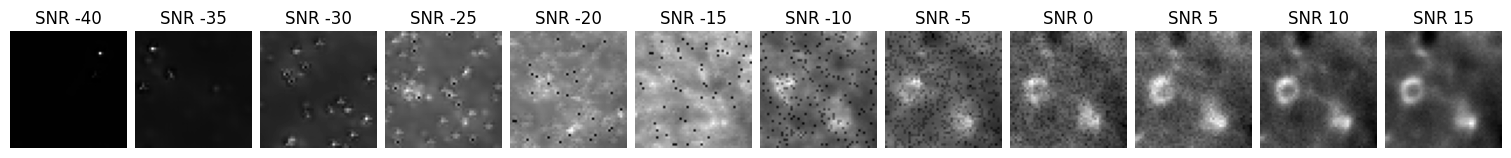

In [23]:
# Load the model checkpoint
checkpoint_path = '/content/drive/MyDrive/MastersThesis/Analysis/Checkpoints/GAP 3D: minPSNR: -40, Window: (32, 128, 128), Params: 2076225/epoch=10-val_loss=-0.02.ckpt'
checkpoint = torch.load(checkpoint_path)
model_GAP3D.load_state_dict(checkpoint['state_dict'])
model_GAP3D = model_GAP3D.to(device)
model_GAP3D.eval()

# Initialize list to store cropped denoised images
cropped_denoised_images = []

# Define the test range
test_range = snr_keys_test = list(test_dict.keys())
print(f"Testing PSNRs {test_range}")

for psnr in test_range:
    noisy_test = test_dict[psnr]["noisy_test"].unsqueeze(0)
    gt_test = test_dict[psnr]["gt_test"].unsqueeze(0)

    noisy_test_GAP = noisy_test[:, :64, ...]
    gt_test_GAP = gt_test[:, :64, ...]

    # Normalize test data in the same way as the training data
    noisy_test_GAP = noisy_test_GAP / (noisy_test_GAP.mean() + 1e-8)
    gt_test_GAP = gt_test_GAP / (gt_test_GAP.mean() + 1e-8)

    # Denoise the image
    with torch.no_grad():
        data = noisy_test_GAP.to(device)
        output = torch.exp(model_GAP3D(data[None, ...])).detach().cpu()
        data = data.cpu()
        output = data.sum() * output / output.sum()
        output_GAP = output.squeeze(0).squeeze(0)

    # Select the middle 50x50 pixels of the denoised image
    crop_size = 50
    image_index = 3  # Select which image to use

    # Calculate the center coordinates
    center_y, center_x = output_GAP.shape[1] // 2, output_GAP.shape[2] // 2

    # Crop the central 50x50 region of the denoised image
    cropped_denoised = output_GAP[image_index,
                                  center_y - crop_size // 2: center_y + crop_size // 2,
                                  center_x - crop_size // 2: center_x + crop_size // 2]

    # Append the cropped denoised image to the list
    cropped_denoised_images.append(cropped_denoised)

# Plot all cropped denoised images side by side
fig, axs = plt.subplots(1, len(cropped_denoised_images), figsize=(15, 5), constrained_layout=True)

for i, img in enumerate(cropped_denoised_images):
    axs[i].imshow(img, cmap='gray', vmax=img.max())  # Use vmax based on each image's max value for consistent contrast
    axs[i].axis('off')
    axs[i].set_title(f'SNR {test_range[i]}')

#plt.savefig('/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/GAP PSNR -40/cropped_denoised_images_UNIFORM.png')
plt.show()

# Diversity Denoising

In [24]:
import torch
import numpy as np

def sample_image_3d(input_image,
                    model,
                    max_photons=None,
                    max_its=500000,
                    max_psnr=-15,
                    save_every_n=5,
                    beta=0.1):
    '''
    Samples a 3D image using Generative Accumulation of Photons (GAP) based on an initial photon image.
    Parameters:
        input_image (torch tensor): the initial photon image, containing integers (batch, channel, z, y, x).
        model: the network used to predict the next photon location.
        max_photons (int): stop sampling when image contains more photons.
        max_its (int): stop sampling after max_its iterations.
        max_psnr (float): stop sampling when pseudo PSNR is larger max_psnr
        save_every_n (int): store and return images at every nth step.
        beta (float): photon number is increased exponentially by factor beta in each step.
    Returns:
        denoised (numpy array): denoised image at the end of that sampling process.
        photons (numpy array): photon image at the end of the sampling process.
        stack (list): list of numpy arrays containing intermediate results.
        i (int): number of executed iterations.
    '''

    start = input_image.clone()
    photons = start
    photnum = 1

    denoised = None
    stack = []

    sumDenoised = start
    region = 64

    for i in range(max_its):

        # compute the pseudo PSNR
        psnr = np.log10(photons.mean().item() + 1e-50) * 10
        print(psnr)
        psnr = max(-40, psnr)

        if (max_photons is not None) and (photons.sum().item() > max_photons):
            break

        if psnr > max_psnr:
            break

        # Denoising the photons using the model
        denoised = model(photons).detach()
        denoised = denoised - denoised.max()
        denoised = torch.exp(denoised)
        denoised = denoised / (denoised.sum(dim=(-1, -2, -3), keepdim=True) + 1e-8)

        # Save intermediate results if necessary
        if (save_every_n is not None) and (i % save_every_n == 0):
            # Note: Here we save a central slice of the 3D volume
            mid_z = denoised.shape[2] // 2  # Mid-slice along the z-axis
            imgsave = denoised[0, 0, mid_z, :, :].detach().cpu()
            imgsave = imgsave / imgsave.max()
            photsave = photons[0, 0, mid_z, :, :].detach().cpu()
            photsave = photsave / max(photsave.max(), 1)
            combi = torch.cat((photsave.unsqueeze(0), imgsave.unsqueeze(0)), 0)
            stack.append(combi.numpy())

        # Increase photon number
        photnum = max(beta * photons.sum(), 1)

        # Draw new photons
        new_photons = torch.poisson(denoised * photnum)

        # Add new photons
        photons = photons + new_photons

    return denoised[...].detach().cpu().numpy(), photons[...].detach().cpu().numpy(), stack, i


In [25]:
psnr = -20
noisy_video = test_dict[psnr]["noisy_test"].unsqueeze(0)
gt_video    = test_dict[psnr]["gt_test"]


checkpoint_path = '/content/drive/MyDrive/MastersThesis/Analysis/Checkpoints/GAP 3D: minPSNR: -40, Window: (32, 128, 128), Params: 2076225/epoch=10-val_loss=-0.02.ckpt'
checkpoint = torch.load(checkpoint_path)
model_GAP3D.load_state_dict(checkpoint['state_dict'])
model = model_GAP3D.to(device)


inference_frames = 32
input_video = noisy_video[:,:inference_frames,...]
ground_truth_mid_frame = gt_video[inference_frames//2]

input_video                = input_video  / (input_video.mean() + 1e-8)
ground_truth_mid_frame     = ground_truth_mid_frame  / ground_truth_mid_frame.mean() + 1e-8



input_video = input_video.unsqueeze(0)


print(ground_truth_mid_frame.shape)
print(input_video.shape)

torch.Size([256, 256])
torch.Size([1, 1, 32, 256, 256])


-5.177193972935941e-07
0.21197020415849377
0.4239149655654987
0.6362302158296694
0.846863818201611
1.058339249480361
1.2702737619184115
1.482325534252922
1.6947361816916175
1.90562926895449
2.1176292921003177
2.328924124480838
2.5413322598183266
2.7532052563069804
2.9646862578895745
3.1771650772913596
3.388711018902129
3.600454962989208
3.812201566333994
4.0238924134032015
4.235543797804231
4.44807626810869
4.659779739674828
4.871078414404394
5.083159518155318
5.295031185624273
5.507377758604727
5.719144573422388
5.930892711182739
6.14319890030358
6.35512189768982
6.567059398154447
6.778714085101565
6.990809891857709
7.2023495287365735
7.413882563254308
7.62609096864427
7.838133041568579
8.05013968666799
8.262004466052856
8.47409426852829
8.685786282649463
8.897538535761946
9.110009865918274
9.321936917548385
9.533585883740859
9.745376194371344
9.956965886370273
10.168985759533358


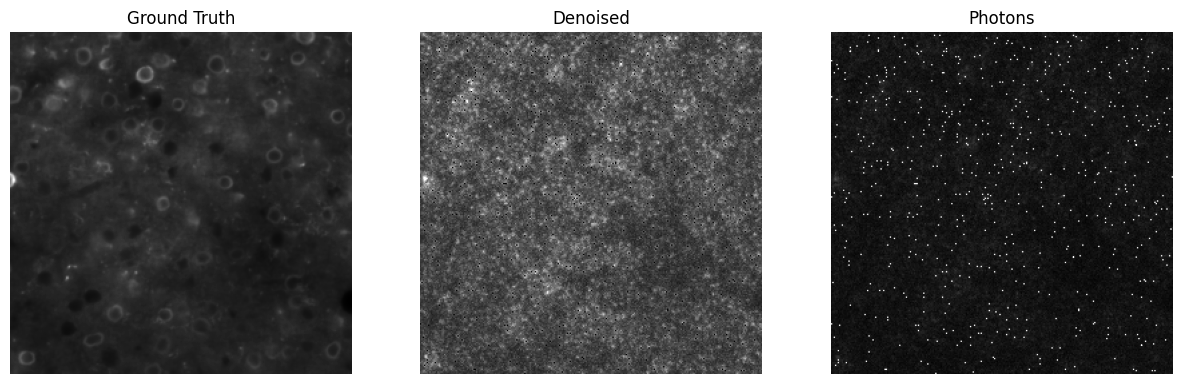

_______________________________________ 48
Time (s): 22.43848705291748 Time per image (s): 22.43848705291748


In [26]:
import matplotlib.pyplot as plt
import time
import numpy as np
import torch

# Define the dimensions of the 3D image
channels = 1
batch_size = 1
pixels_x = 128
pixels_y = 128
pixels_z = 32



# Create an initial image with zeros
inp_img1 = torch.zeros(batch_size, channels, pixels_z, pixels_y, pixels_x).to(device)

inp_img2 = input_video.to(device)
for i in range(1):
    startTime = time.time()

    # Sample the image(s)
    denoised, photons, stack, iterations = sample_image_3d(inp_img2,
                                                            model,
                                                            beta=0.05,
                                                            max_photons=None,
                                                            max_its=15000,
                                                            save_every_n=5,
                                                            max_psnr=10)

    # Visualize slices from the 3D volumes
    for j in range(denoised.shape[0]):
        # Select a slice from the middle of the z-dimension
        mid_z = denoised.shape[2] // 2

        # Denoised Image
        plt.figure(figsize=(15, 5))

        # Ground Truth
        plt.subplot(1, 3, 1)
        plt.imshow(ground_truth_mid_frame, cmap='gray')
        plt.title('Ground Truth'.format(mid_z))
        plt.axis('off')

        # Denoised Image
        plt.subplot(1, 3, 2)
        plt.imshow(denoised[j, 0, mid_z, :, :], cmap='gray', vmin=0, vmax=np.percentile(denoised[j], 99.99))
        plt.title('Denoised'.format(mid_z))
        plt.axis('off')

        # Photon Counts
        plt.subplot(1, 3, 3)
        plt.imshow(photons[j, 0, mid_z, :, :], cmap='gray', vmin=0, vmax=np.percentile(photons[j], 99.99))
        plt.title('Photons'.format(mid_z))
        plt.axis('off')

        # Specify the path where the image will be saved
        save_path = f'/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/ImageGen/{psnr}.png'


        # Save the figure as a PNG file
        plt.savefig(save_path, format='png', dpi=300)

        plt.show()

    print('_______________________________________', iterations)

    endTime = time.time()
    elapsedTime = endTime - startTime
    print('Time (s):', elapsedTime, 'Time per image (s):', elapsedTime / denoised.shape[0])


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100


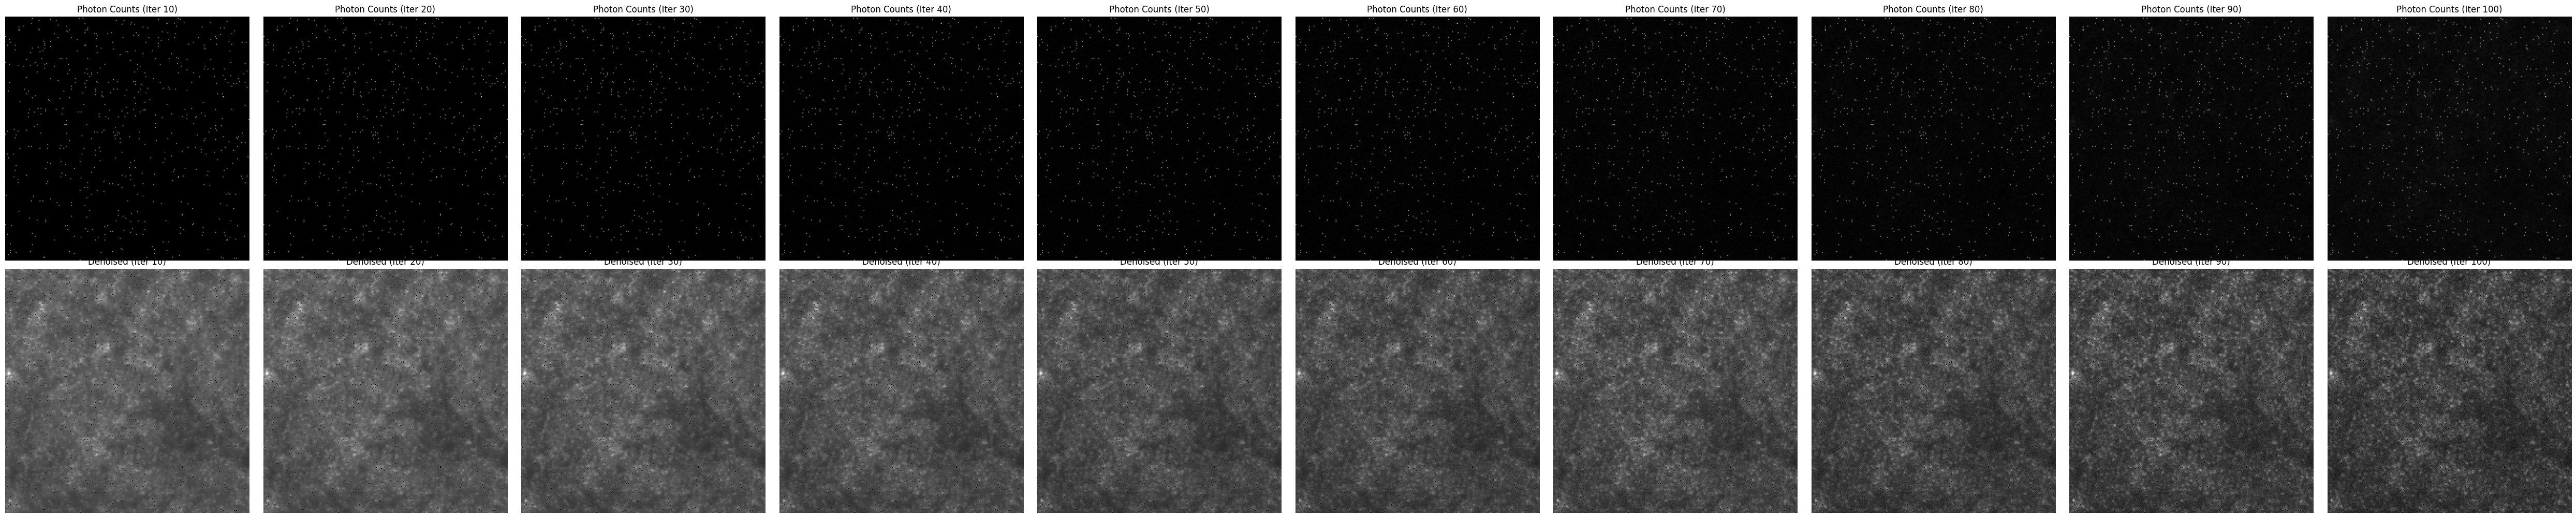

In [27]:
import matplotlib.pyplot as plt

# Define the number of iterations and figure size based on the length of the stack
num_iterations = len(stack)
fig, axes = plt.subplots(2, num_iterations, figsize=(5 * num_iterations, 10))  # 2 rows, N columns

# Iterate through each image in the stack
for i in range(num_iterations):
    im = stack[i]
    print(f"Iteration {(i + 1) * 10}")

    # Photon Counts (Top Row)
    axes[0, i].imshow(im[0], cmap='gray', vmax=0.9)
    axes[0, i].set_title(f'Photon Counts (Iter {(i + 1) * 10})')
    axes[0, i].axis('off')

    # Denoised Image (Bottom Row)
    axes[1, i].imshow(im[1], cmap='gray', vmax=0.9)
    axes[1, i].set_title(f'Denoised (Iter {(i + 1) * 10})')
    axes[1, i].axis('off')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Display the images
plt.show()
